In [ ]:
# import the necessary libraries 

import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F
import timm

# GradCAM related imports
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

import warnings

warnings.filterwarnings('ignore')

# predefine function
from utils.classes import classes

import cv2
import matplotlib.cm as cm

In [ ]:
# check the device is cpu or gpu

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cpu')

In [7]:
# Load model from timm 

model = timm.create_model('efficientvit_b2.r288_in1k', pretrained=True)  # Model from timm
model.to(device)

model.load_state_dict(torch.load("../artifacts/training/model.pth", map_location=device))
model.eval()

print("model is successfully loaded")

model is successfully loaded


C:\Users\User\AppData\Local\Temp\ipykernel_13744\888590633.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../artifacts/training/model.

In [ ]:
# Load and preprocess image

img = Image.open('../artifacts/preprocessed/test_data/8-cell Grade A/image116.jpg').convert('RGB')
transform = transforms.Compose([
    transforms.Resize((288, 288)),
    transforms.ToTensor(),
])
input_tensor = transform(img).unsqueeze(0).to(device)

In [ ]:
# Predict

with torch.no_grad():
    outputs = model(input_tensor)
    _, predicted_class = torch.max(outputs, 1)

print(f"Predicted class index: {classes(predicted_class.item())} ✅")

Predicted class index: 8-cell Grade A ✅


In [13]:
# Grad-CAM settings

target_layer = model.stem[-1].main.depth_conv.conv # last layer

cam = GradCAM(model=model, target_layers=[target_layer])
targets = [ClassifierOutputTarget(predicted_class.item())]
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]


In [17]:
# ---- FULL FOCUS HEATMAP STEPS ----
# Increase heatmap contrast
grayscale_cam = np.power(grayscale_cam, 0.5)  # Make important areas stronger
grayscale_cam = np.clip(grayscale_cam * 2.0, 0, 1)  # Amplify

# Prepare original image
img_np = transform(img).permute(1, 2, 0).cpu().numpy()
img_np = np.clip(img_np, 0, 1)

# Create colored heatmap
colored_heatmap = cm.jet(grayscale_cam)[..., :3]  # Take RGB only

# Resize heatmap
colored_heatmap = cv2.resize(colored_heatmap, (img_np.shape[1], img_np.shape[0]))

# Blend heatmap and original
alpha = 0.6  # Higher alpha for stronger heatmap
blended_image = (1 - alpha) * img_np + alpha * colored_heatmap
blended_image = np.clip(blended_image, 0, 1)


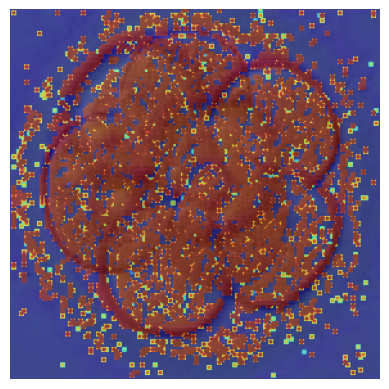

In [18]:
# Show result
plt.imshow(blended_image)
plt.axis('off')
plt.show()